In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import io

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve

%matplotlib inline

# Problem: Given a patient's record, classify if the patient has heart disease

##  Load and explore heart disease data

Out of the total 76 features in the original dataset from Kaggle, the following 14 were selected:

1. age - age in years 
2. sex - (1 = male; 0 = female) 
3. cp - chest pain type 
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
    * anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl 
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        - can range from mild symptoms to severe problems
        - signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
        - Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved 
9. exang - exercise induced angina (1 = yes; 0 = no) 
10. oldpeak - ST depression induced by exercise relative to rest 
    * looks at stress of heart during excercise
    * unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy 
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising 
14. **target - presence of heart disease (1 = yes, 0 = no) 

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving heart-disease.csv to heart-disease.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['heart-disease-data.csv']))

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Percentage of records with and without heart disease

In [ ]:
percentage_with_heart_disease = df['target'].value_counts(normalize = True)[1]
percentage_without_heart_disease = df['target'].value_counts(normalize = True)[0]

print(f"{percentage_with_heart_disease * 100} % of people in the data have heart disease")
print(f"{percentage_without_heart_disease * 100} % of people in the data do not have heart disease")

54.45544554455446 % of people in the data have heart disease
45.54455445544555 % of people in the data do not have heart disease


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


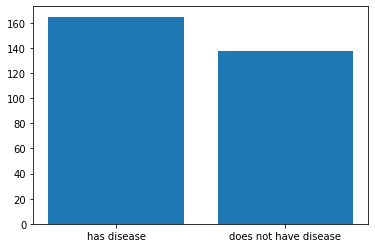

In [ ]:
bar_labels = ['has disease', 'does not have disease']
positive_number = df['target'].value_counts()[1]
negative_number = postive_number = df['target'].value_counts()[0]
all_cases = [positive_number, negative_number]
plt.bar(range(len(bar_labels)), all_cases)
ax = plt.subplot()
ax.set_xticks(range(2))
ax.set_xticklabels(bar_labels)
plt.show()

In [ ]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Determine coorelation between columns


In [ ]:
correlation = df.corr()
correlation

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


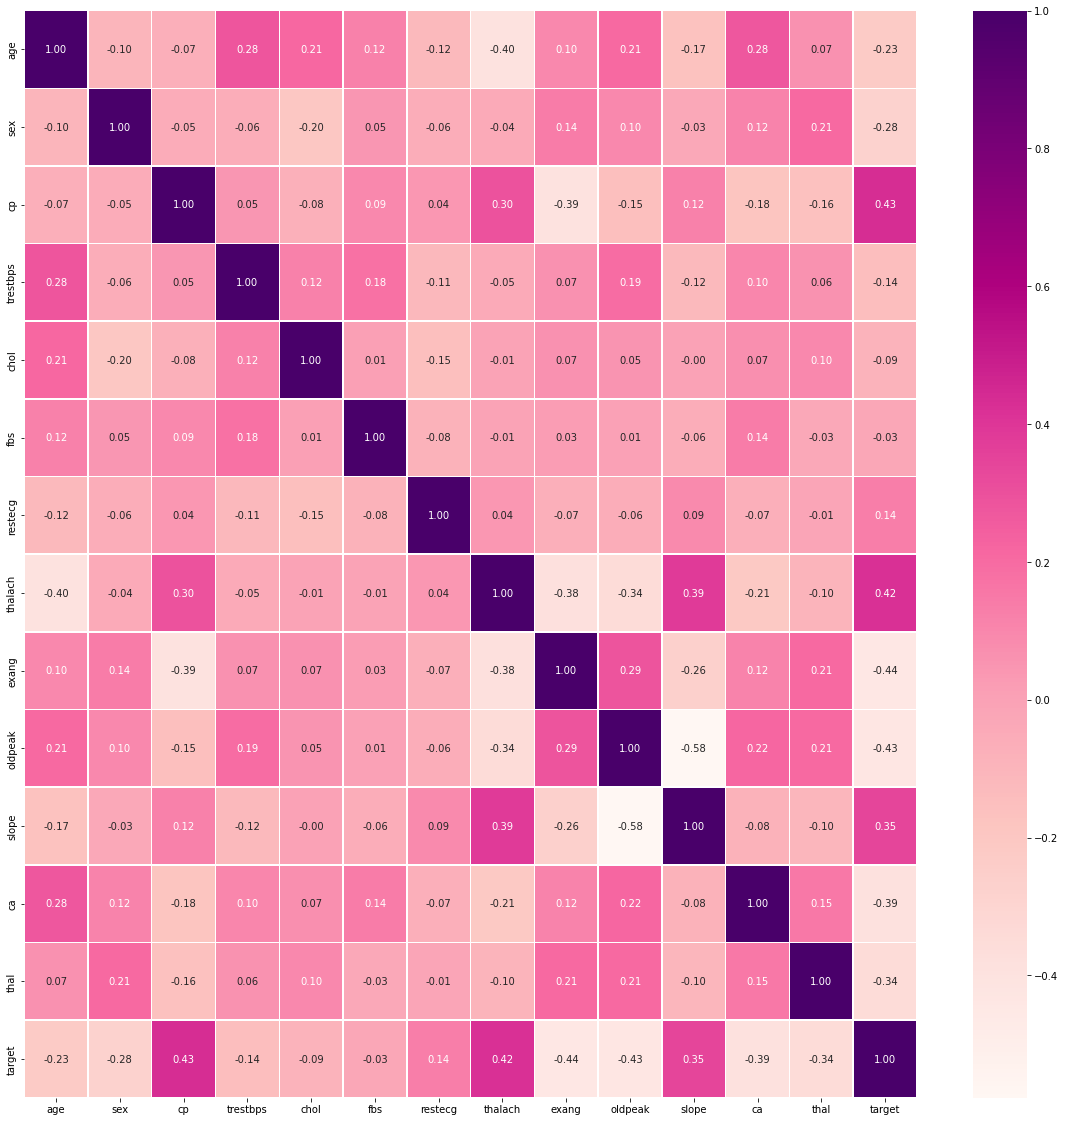

In [ ]:
plt.figure(figsize = (20, 20))
sns.heatmap(correlation, cmap="RdPu", linewidth = 0.5, fmt = ".2f", annot = True);

## Modelling

Separate features and target variable

In [ ]:
X = df.drop("target", axis = 1)
Y = df['target']

In [ ]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [ ]:
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

### Split data for training and testing


In [ ]:
np.random.seed(42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2
202,58,1,0,150,270,0,0,111,1,0.8,2,0,3
196,46,1,2,150,231,0,1,147,0,3.6,1,0,2
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2
176,60,1,0,117,230,1,1,160,1,1.4,2,2,3


In [ ]:
Y_test.head()

179    0
228    0
111    1
246    0
60     1
Name: target, dtype: int64

### Models we will use:


*   Logisitic Regression
*   RandomForest
*   K-Nearest Neighbors



In [ ]:
ml_models = {
    "logistic_regression": LogisticRegression(),
    "knn": KNeighborsClassifier(),
    "random_forest": RandomForestClassifier(),
}

In [ ]:
def train_and_evaluate(ml_models, X_train, X_test, Y_train, Y_test):
  """
    Input: Takes a dictionary of models, training and test data. 
    Output: trains the model and stores the evaluations (accuracy) in a dictionary.
  """

  model_evaluation = {}
  
  for model_name, model in ml_models.items():
    model.fit(X_train, Y_train)
    # Compute accuracy
    model_evaluation[model_name] = model.score(X_test, Y_test)
  
  return model_evaluation


model_evals = train_and_evaluate(ml_models, X_train, X_test, Y_train, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Model Accuracy

In [ ]:
model_evals

{'knn': 0.6885245901639344,
 'logistic_regression': 0.8852459016393442,
 'random_forest': 0.8524590163934426}

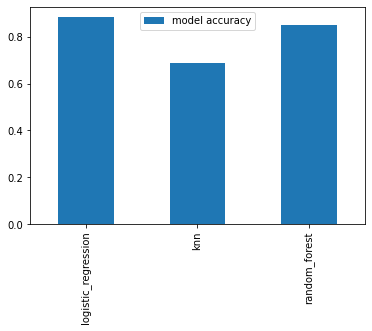

In [ ]:
models_compared = pd.DataFrame(model_evals, index=['model accuracy'])
models_compared.T.plot.bar();

## Hyperparameter Search

In [ ]:
# Setup hyperparameters to tune
log_regr_params = {
    "C": np.logspace(-4, 4, 20),
    "solver":  ['newton-cg', 'liblinear'],
}

random_forest_params = {
    'max_features': ['sqrt', 'log2'],
    "n_estimators": np.arange(10, 1000, 50),
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2)
}

### Tune Logistic Regression 

In [ ]:
# Tune hyperparameters for logistic regression
log_regr_tuned = RandomizedSearchCV(LogisticRegression(),
                                   cv = 5,
                                   n_iter = 20,
                                   verbose = True,
                                   param_distributions=log_regr_params)

np.random.seed(42)
# Train logistic regression with new hyper parameters
log_regr_tuned.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['newton-cg', 'liblinear']},
                   verbose=True)

In [ ]:
log_regr_tuned.best_params_

{'C': 0.23357214690901212, 'solver': 'liblinear'}

In [ ]:
log_regr_tuned.score(X_test, Y_test)

0.8852459016393442

### Tune Random Forest 

In [ ]:
# Tune hyperparameters for logistic regression
random_forest_tuned = RandomizedSearchCV(RandomForestClassifier(),
                                   cv = 10,
                                   n_iter = 20,
                                   verbose = True,
                                   param_distributions = random_forest_params)

np.random.seed(42)
# Train logistic regression with new hyper parameters
random_forest_tuned.fit(X_train, Y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [ ]:
random_forest_tuned.best_params_

{'max_features': 'log2',
 'min_samples_leaf': 15,
 'min_samples_split': 12,
 'n_estimators': 560}

In [ ]:
random_forest_tuned.score(X_test, Y_test)

0.8688524590163934

Logistic Regression perfomed better!

## Evaluation

#### Confusion Matrix


Text(6.0, 0.5, 'predicted label')

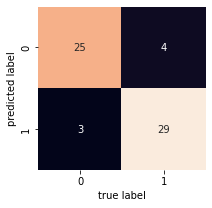

In [ ]:
Y_predicted = log_regr_tuned.predict(X_test)

fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(confusion_matrix(Y_test, Y_predicted),
                     annot=True, 
                     cbar=False)
plt.xlabel("true label")
plt.ylabel("predicted label")

#### Receiver Operating Characteristic (ROC) Curve

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


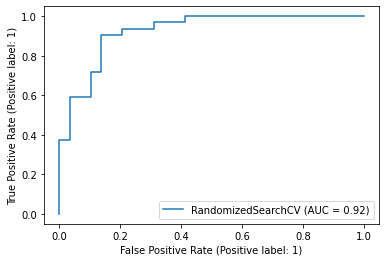

In [ ]:
plot_roc_curve(log_regr_tuned, X_test, Y_test);

### Classification Report


In [ ]:
print(classification_report(Y_test, Y_predicted))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



### Feature Importance


In [ ]:
log_regr = LogisticRegression(C = log_regr_tuned.best_params_['C'], solver = log_regr_tuned.best_params_['solver'])
log_regr.fit(X_train, Y_train)

feature_importance = dict(zip(df.columns, list(log_regr.coef_[0])))
feature_importance

{'age': 0.003699220776580221,
 'ca': -0.6516534770577476,
 'chol': -0.0017036439067759743,
 'cp': 0.6747282587404362,
 'exang': -0.6312040612837573,
 'fbs': 0.047876881148997324,
 'oldpeak': -0.5759095045469952,
 'restecg': 0.3349019815885189,
 'sex': -0.9042409028785717,
 'slope': 0.4709514073081419,
 'thal': -0.6998420764664995,
 'thalach': 0.02472938284108309,
 'trestbps': -0.011613401339975146}